# Elephant Tutorials: Computing the spectra of spike trains

## Overview
This tutorial is designed to demonstrate the process of computing and analyzing the power spectral densities (PSDs) of spike trains, an essential tool in neuroscience for understanding the frequency components exhibited by neural activity. These methods include traditional approaches (such as Welch and multitaper PSD), as well as other computational techniques inspired by neuroscience research. We will compare results obtained using these methods with theoretical spectra, enabling deeper understanding and validation of the methods.

## Prerequisites
- Packages: Neo (0.13.4), Elephant (1.2.0)

## Learning Objectives
By the end of this tutorial, you will be able to:
- Understand the fundamental concepts of power spectral analysis for neural spike data
- Apply appropriate methods to compute and interpret power spectra from spike trains
- Visualize and analyze spectral components of neuronal activity

## Imports

In [26]:
# Standard libraries
import numpy as np              # Numerical computing
import matplotlib.pyplot as plt # Plotting library

# Domain-specific libraries
import quantities as pq         # Physical quantities with units
import neo                      # Electrophysiology data handling
import elephant                 # Neural data analysis algorithms
import viziphant                # Visualization tools for elephant

# Check versions of critical packages
print(f"neo version: {neo.__version__}")
print(f"elephant version: {elephant.__version__}")
print(f"viziphant version: {viziphant.__version__}")

%matplotlib inline

neo version: 0.13.4
elephant version: 1.2.0b1
viziphant version: 0.4.0


## Generate a compound gamma process

Let's get started by creating a synthetic spike train using a superposition of two stationary gamma processes. We will use this in the following tutorial to perform and interpret spectral analyses of that spike train data. First, we define parameters for two gamma spiketrains. The shape factor of a gamma process defines its regularity, with higher values leading to more regular processes. A shape factor of 1 is equivalent to a Poisson process. In this tutorial, we are specifically interested in periodicity of the resulting spike train, and therefore, we choose high values for the shape factor.

In [27]:
rate_1 = 20 * pq.Hz         # rate of the stationary gamma process 1
gamma_shape_factor_1 = 100  # shape factor defining the regularity (higher values are more clock-like)

rate_2 = 30 * pq.Hz         # rate of the stationary gamma process 2
gamma_shape_factor_2 = 100  # shape factor defining the regularity (higher values are more clock-like)

duration = 2000 * pq.s      # duration of the spike trains

Next, we use Elephant to generate gamma processes with the above two parameters.

In [28]:
# Create a stationary Gamma process with the given parameters
gamma_process1 = elephant.spike_train_generation.StationaryGammaProcess(
    rate=rate_1,
    shape_factor=gamma_shape_factor_1,
    t_start=0 * pq.ms,
    t_stop=duration
)

# Generate the 1st spike train
st1 = gamma_process1.generate_spiketrain()

# Create a stationary Gamma process with the given parameters
gamma_process2 = elephant.spike_train_generation.StationaryGammaProcess(
    rate=rate_2,
    shape_factor=gamma_shape_factor_2,
    t_start=0 * pq.ms,
    t_stop=duration
)

# Generate the 2nd spike train
st2 = gamma_process2.generate_spiketrain()

# Merge the two spiketrains into a single one
st=st1.merge(st2)

In [29]:
# Show resulting Neo SpikeTrain object
st

SpikeTrain containing 99965 spikes; units s; datatype float64 
time: 0.0 s to 2000.0 s

We are left with a spike train with a duration of 2000 seconds. We chose this very long duration to prevent our analysis to become overshadowed by effects of too little data -- after all, Fourier analysis in principle requires time series of infinite length. Given our firing rates of 20 Hz and 30 Hz, we expect about 50 spikes per second, therefore approx. 2000 s * 50 Hz = 100000 spikes, which fits our resulting data.

## Plot the first seconds of the spike train

First, let's have a look at how this spike train looks. To this end, we plot the first second of data using a function of the viziphant module.

<Axes: xlabel='Time (s)'>

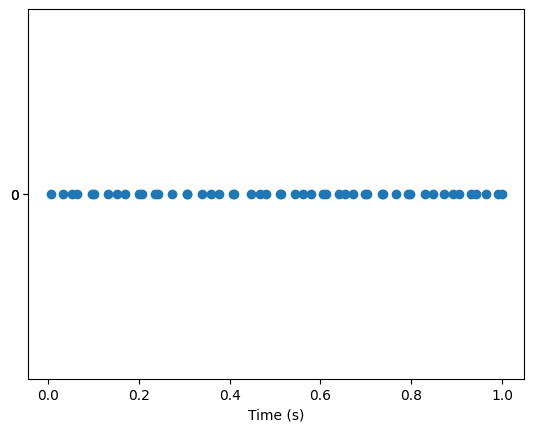

In [30]:
# Slice spike train to first few seconds before plotting
viziphant.rasterplot.rasterplot(
    [st.time_slice(t_start=0*pq.ms, t_stop=1000*pq.ms)])

By the naked eye, the spike train looks rather irregular. To understand how it is composed of different periodic components, we plot the constituent spike trains of the two gamma processes side-by-side.

array([<Axes: >, <Axes: xlabel='Time (s)', ylabel='Spike count'>],
      dtype=object)

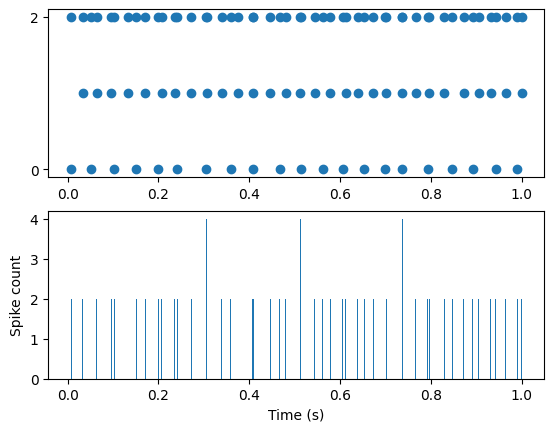

In [31]:
# Slice spike train to first few seconds before plotting
viziphant.rasterplot.rasterplot(
    [st1.time_slice(t_start=0*pq.ms, t_stop=1000*pq.ms),
     st2.time_slice(t_start=0*pq.ms, t_stop=1000*pq.ms),
     st.time_slice(t_start=0*pq.ms, t_stop=1000*pq.ms)],
    histogram_bins=500)

Clearly, the generating spike trains are highly regular, as expected from the shape factor. If you alter the shape factors above, you will be able to see how you can increase or decrease the regularity. The CV2 provides a measure to quantify the degree of regularity of a spike train based on its interval statistics, with low values indicating a high degree of regularity (i.e., little variability in the intervals). Indeed, already a simple superposition is sufficient to obscure any regular components in the spike train.

In [32]:
print(f"CV2 of spike train 1: {elephant.statistics.cv2(elephant.statistics.isi(st1))}")
print(f"CV2 of spike train 2: {elephant.statistics.cv2(elephant.statistics.isi(st2))}")
print(f"CV2 of the compound spike train: {elephant.statistics.cv2(elephant.statistics.isi(st))}")

CV2 of spike train 1: 0.11247116736874739
CV2 of spike train 2: 0.11233636759810836
CV2 of the compound spike train: 0.9543062538013755


In the following, let's try to recover the constituent regular spike trains using power spectral analysis.

## Create a binned representation of the spike train

For most approaches to Fourier analysis, we consider the spike train to be represented as a regular time series, where individual samples indicate the spike count within a bin.

To start, we will use Elephant to create a binned representation of our Neo `SpikeTrain` object. Here, we use a standard binning of 1 ms.

In [33]:
bin_size = 1*pq.ms
bst = elephant.conversion.BinnedSpikeTrain(
    st, bin_size=bin_size)

In [34]:
# Show dimensions of the spike train
assert(bst.to_array().shape[1] == (duration/bin_size).simplified.magnitude)
bst.to_array().shape

(1, 2000000)

As expected, the resulting vector will be of length 1,000 bins/s * 2,000 s = 2,000,000 bins

## Convert the binned spike train to a regular, normalized time series

In addition to the `BinnedSpikeTrain` object, we will also transform the spiketrain into a Neo `AnalogSignal` that contains the biined spike train, normalized by the bin size (i.e., sampling period). Here, this normalization is in principle arbitrary, but guarantees that our resulting power spectrum is interpretable in terms of spike rates, as we will see later.

In [35]:
binned_spikes_timeseries = neo.AnalogSignal(
    bst.to_array().transpose()/bst.bin_size.magnitude*pq.dimensionless,
    t_start=bst.t_start,
    sampling_period=bst.bin_size)

## Welch PSD estimate

Now we are ready to peform our first power spectral density (PSD) estimate. We start with a standard go-to approach: Welch's algorithm. Here, the PSD is calculated using a standard Fourier analysis of the binned and normalized spike count time series. However, in order to improve the estimate, the time series is first subdivided into shorter time series. The spectra are then calculated individually on these shorter segments, and subsequently averaged. Naturally, this will lead to PSDs with a coarser resolution, but the averaging approach will lead to a more stable and less noisy estimate per bin.

Here, we choose to divide the data into 10 segments with no overlap. Playing around with these parameters will help to gain an understanding of the PSD estimate.

In addition, each window is tapered (i.e., multiplied) by a window function. These minimize distortions cause by the finite duration of the sample, especially due to spurious frequencies due to the abrupt end of the signal at the borders. By default, this is a so-called Hanning window.

In [36]:
n_segments = 10
overlap = 0
f_w,psd_w = elephant.spectral.welch_psd(
    bst, n_segments=n_segments, overlap=overlap)
# Elephant <1.2.0:
# f_w,psd_w = elephant.spectral.welch_psd(
#     binned_spikes_timeseries, n_segments=n_segments, overlap=overlap)

To plot this and future PSD spectra in the range 0-100 Hz, we define a small function `plot_spectrum`.

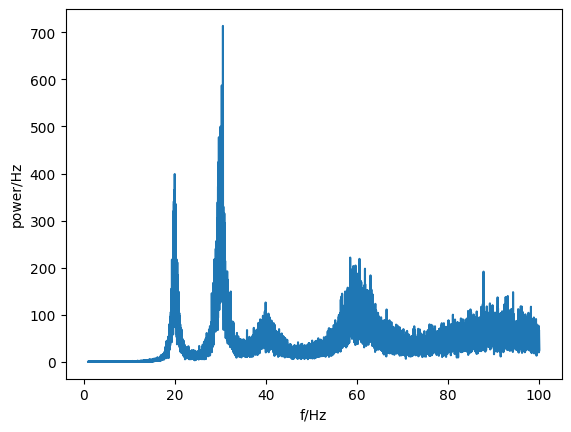

In [37]:
def plot_spectrum(f, psd):
    # Limit frequency axis to 1-100 Hz
    lower_f_index = np.where(f.rescale(pq.Hz).magnitude>1)[0][0]
    upper_f_index = np.where(f.rescale(pq.Hz).magnitude>100)[0][0]
    plt.plot(f[lower_f_index:upper_f_index], np.transpose(psd[0, lower_f_index:upper_f_index]/2))
    plt.xlabel("f/Hz")
    plt.ylabel("power")

plot_spectrum(f_w, psd_w)

The PSD shows clear peaks at 20 Hz and 30 Hz, the frequencies of our regular constituent processes, however, there is still considerable noise.

Remember the normalization that we applied to generating the Neo `AnalogSignal` time series (a normalization that Elephant >=1.2 will automatically apply if a `BinnedSpikeTrain` object is passed). This normalization will guarantee the the PSD will equal the average rate of the process in frequency regions where no regularity is observed. To test this, we calculate the average value per bin of the PSD at high frequencies. Indeed, this matches the rate of the input process:

In [38]:
# Check average power in tail
lower_f_index = np.where(f_w>50)[0][0]
upper_f_index = np.where(f_w>100)[0][0]
print(f"Average power >50 Hz: {np.mean(np.transpose(psd_w[0,lower_f_index:upper_f_index])/2)}")

Average power >50 Hz: 52.39304935272681 1/Hz


## Multi-taper PSD estimate

Next, let's try a multi-taper PSD estimate. The idea here is not so different from Welch: again, we average multiple estimates of the PSD. However, this time use the complete time series, but for estimate we "taper" the time series by a unique windowing function, the Slepian tapers. Each of these windows emphasize different parts of the time series, and therefore yield distinct estimates based on different weightings of the data. As each estimate uses the complete time series, the resulting PSD is sampled at maximal resolution.

In [39]:
f_mt, psd_mt = elephant.spectral.multitaper_psd(
    bst)
# Elephant <1.2.0:
# f_mt, psd_mt = elephant.spectral.multitaper_psd(
#     binned_spikes_timeseries)

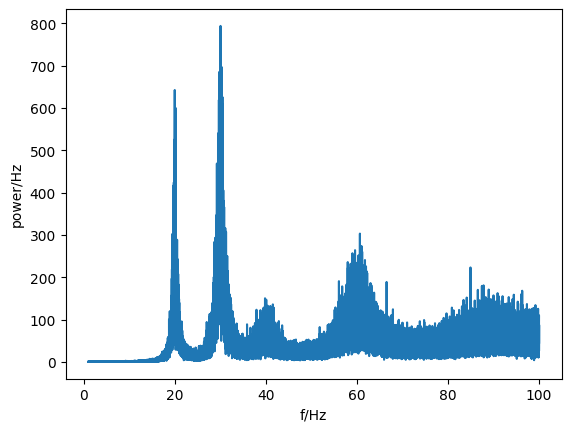

In [40]:
plot_spectrum(f_mt, psd_mt)

We observe a similar spectrum, at higher resolution, but also with higher noise levels. Again, our normalization makes the amplitude of the PSD interpretable:

In [41]:
# Check average power in tail
lower_f_index = np.where(f_mt>50)[0][0]
upper_f_index = np.where(f_mt>100)[0][0]
print(f"Average power >50 Hz: {np.mean(np.transpose(psd_mt[0,lower_f_index:upper_f_index])/2)}")

Average power >50 Hz: 52.39949183109181 1/Hz


## Multi-segment averaged multi-taper PSD estimate

Now, let's combine the best of these two methods: Average individual spectra using multiple tapers, but using a time series that's cut up in individual parts (Welch).

In [42]:
f_mtn, psd_mtn = elephant.spectral.segmented_multitaper_psd(
    bst,
    n_segments=n_segments,
    overlap=overlap)
# Elephant <1.2.0:
# f_mtn, psd_mtn = elephant.spectral.multitaper_psd(
#     binned_spikes_timeseries,
#     n_segments=n_segments,
#     overlap=overlap)


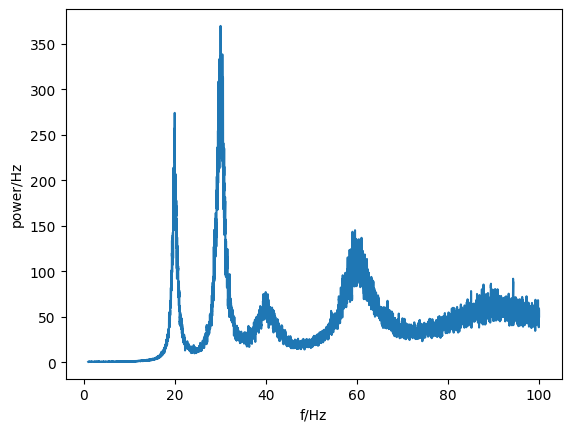

In [43]:
plot_spectrum(f_mtn, psd_mtn[0,:])

This procedure yields a spectrum where both components of the compound gamma process are clearly visible. Also the higher harmonics can be much more clearly identified as compared to the Welch or multi-taper estimates alone.

In [44]:
# Check average power in tail
lower_f_index = np.where(f_mtn>50)[0][0]
upper_f_index = np.where(f_mtn>100)[0][0]
print(f"Average power >50 Hz: {np.mean(np.transpose(psd_mtn[0,0,lower_f_index:upper_f_index])/2)}")

Average power >50 Hz: (52.40407943725586+0j) 1/Hz


## Straight-Forward FFT power spectra

How much do these methods help in obtaining a clean PSD estimate as compared to simply performing a standard FFT on the data? Here we make a comparison based on a function published in Bos et al., 2018, https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1005132


In [45]:
def powerspec(data, tbin, Df=None, units=False, N=None):
    '''
    Calculate (smoothed) power spectra of all timeseries in data. 
    If units=True, power spectra are averaged across units.
    Note that averaging is done on power spectra rather than data.

    Power spectra are normalized by the length T of the time series -> no scaling with T. 
    For a Poisson process this yields:

    **Args**:
       data: numpy.ndarray; 1st axis unit, 2nd axis time
       tbin: float; binsize in ms
       Df: float/None; window width of sliding rectangular filter (smoothing), None -> no smoothing
       units: bool; average power spectrum 

    **Return**:
       (freq, POW): tuple
       freq: numpy.ndarray; frequencies
       POW: if units=False: 2 dim numpy.ndarray; 1st axis unit, 2nd axis frequency
            if units=True:  1 dim numpy.ndarray; frequency series

    **Examples**:
       >>> powerspec(np.array([analog_sig1,analog_sig2]),tbin, Df=Df)
       Out[1]: (freq,POW)
       >>> POW.shape
       Out[2]: (2,len(analog_sig1))

       >>> powerspec(np.array([analog_sig1,analog_sig2]),tbin, Df=Df, units=True)
       Out[1]: (freq,POW)
       >>> POW.shape
       Out[2]: (len(analog_sig1),)

    '''
    if N is None:
        N = len(data)
    freq, DATA = calculate_fft(data, tbin)
    df = freq[1] - freq[0]
    T = tbin * len(freq)
    POW = np.power(np.abs(DATA),2)
    if Df is not None:
        POW = [movav(x, Df, df) for x in POW]
        cut = int(Df / df)
        freq = freq[cut:]
        POW = np.array([x[cut:] for x in POW])
        POW = np.abs(POW)
    assert(len(freq) == len(POW[0]))
    if units is True:
        POW = 1./N*np.sum(POW, axis=0)
        assert(len(freq) == len(POW))
    POW *= 1. / T * 1e3  # normalization, power independent of T
    return freq, POW


def calculate_fft(data, tbin):
    '''
    calculate the fouriertransform of data
    [tbin] = ms
    '''
    if len(np.shape(data)) > 1:
        n = len(data[0])
        return np.fft.fftfreq(n, tbin * 1e-3), np.fft.fft(data, axis=1)
    else:
        n = len(data)
        return np.fft.fftfreq(n, tbin * 1e-3), np.fft.fft(data)

def movav(y, Dx, dx):
    '''
    calculate average of signal y by using sliding rectangular
    window of size Dx using binsize dx
    '''
    if Dx <= dx:
        return y
    else:
        ly = len(y)
        r = np.zeros(ly)
        n = int(np.round((Dx / dx)))
        r[0:int(n / 2.)] = 1.0 / n
        r[-int(n / 2.)::] = 1.0 / n
        R = np.fft.fft(r)
        Y = np.fft.fft(y)
        yf = np.fft.ifft(Y * R)
        return yf

In [46]:
f_fft, psd_fft = powerspec(
    bst.to_array(), tbin=bin_size.rescale(pq.ms).magnitude, Df=None)

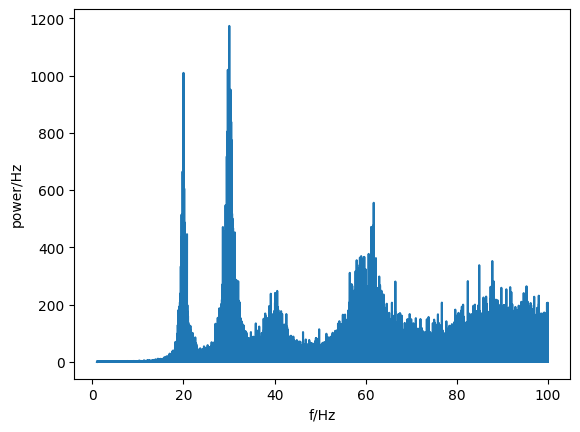

In [47]:
plot_spectrum(f_fft*pq.Hz, psd_fft*pq.dimensionless)

The graphical representation makes it quite clear: Plain FFTs will produce a considerable amount of noise -- yet in this simple example, it is still possible to detect the relevant peaks. As a sanity check, let's look at the power content of the tail again -- despite the noise it should average to about 50 Hz.

In [48]:
# Check average power in tail
lower_f_index = np.where(f_fft>50)[0][0]
upper_f_index = np.where(f_fft>100)[0][0]
print(f"Average power >50 Hz: {np.mean(np.transpose(psd_fft[0,lower_f_index:upper_f_index]))}")

Average power >50 Hz: 52.39771231382296


## Straight-Forward FFT using the Welch algorithm

In principle, a plain FFT should be the same as a Welch algorithm with just one window and a box car windowing function. Let's test this!

In [49]:
f_wfft,psd_wfft = elephant.spectral.welch_psd(
    binned_spikes_timeseries, 
    n_segments=1, 
    window='box')

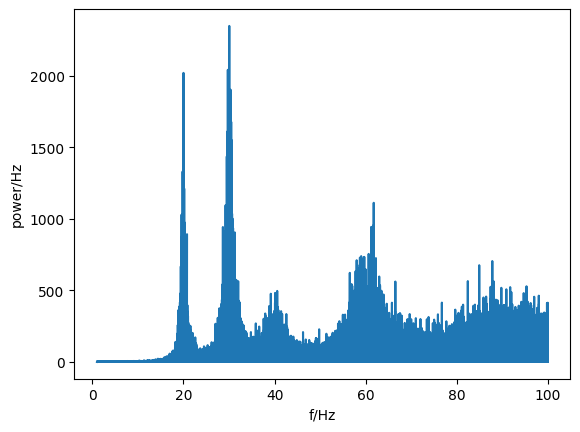

In [50]:
plot_spectrum(f_wfft, psd_wfft)

In [51]:
# Check average power in tail
lower_f_index = np.where(f_wfft>50)[0][0]
upper_f_index = np.where(f_wfft>100)[0][0]
print(f"Average power >50 Hz: {np.mean(np.transpose(psd_wfft[0,lower_f_index:upper_f_index])/2)}")

Average power >50 Hz: 52.397712313822964 1/Hz


## PSD without binning

There is one fundamentally different way of computing the PSD without applying any binning. Representing the spike train as a series of delta functions, it is possible to analytically calculate the Fourier transform as a sum over all spike times. The following implements the procedure based on code provided by Hans Eckehard Plesser.

In [153]:
def fft_transform(fs, T, spike_times):
    """
    Calculate PSD of spike train for given frequencies in a vectorized way.

    Parameters:
    -----------
    fs : array-like
        Frequencies to evaluate in Hz
    T : float
        Total time duration in ms
    spike_times : array-like
        Array of spike times in ms

    Returns:
    --------
    array-like
        Complex Fourier transforms at specified frequencies
    """
    s = np.asarray([sum(np.exp(-1j * 2 * np.pi * f * spike_times/1000. ))
                    * (1. if f==0. else 2.) / (T / 1000.) for f in fs])
    return s

In [154]:
f_zf = np.linspace(0, 500, num=10000)
psd_zf = fft_transform(
    f_zf, 
    duration.rescale(pq.ms).magnitude,
    st.rescale(pq.ms).magnitude)

# Convert Fourier transform to PSD
psd_zf = np.expand_dims(psd_zf, axis=0)
psd_zf[0,:] = np.abs(psd_zf*np.conjugate(psd_zf))*1000

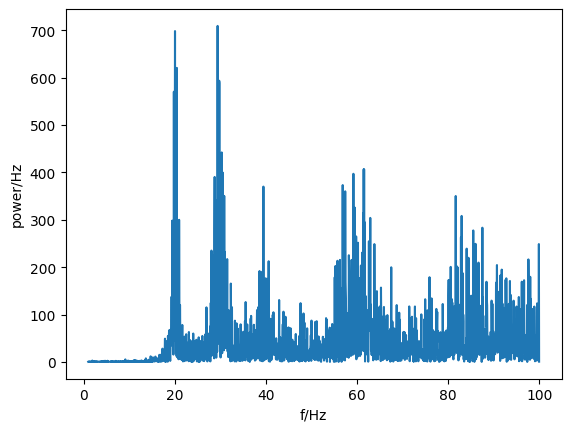

In [155]:
plot_spectrum(f_zf*pq.Hz, psd_zf*pq.dimensionless)

In [156]:
# Check average power in tail
lower_f_index = np.where(f_zf>50)[0][0]
upper_f_index = np.where(f_zf>100)[0][0]
print(f"Average power >50 Hz: {np.mean(np.transpose(psd_zf[0,lower_f_index:upper_f_index])/2)}")

Average power >50 Hz: (53.269670080482776+0j)


Wow, that took a long time. But in return, we obtain a precise spectrum that does not suffer from the estimation off a binned spike time series, as seen for the classic FFT approach above. Nevertheless, the lack of averaging and ultra-fine resolution of the frequency axis leads to a high degree of noise.

## Theoretical spectrum

Now that we have estimated the spectrum using a variety of methods, let's obtain the theoretical spectrum for a superposition of multiple gamma processes with known rate and order parameter, using code provided by Tom Tetzlaff (see: Tetzlaff et al., 2008. Dependence of neuronal correlations on filter characteristics
        and marginal spike train statistics. Neural Computation, 20(9), 2133-2184.)

In [117]:
def psd_gamma_process_theoretical(freqs,rate,order):
    '''
    Theoretical power spectrum of a homogeneous Gamma process with integer order gamma
    (see, e.g., eqs.(3.11) and (3.12) in [1]).
    
    [1] Tetzlaff et al. (2008). Dependence of neuronal correlations on filter characteristics 
        and marginal spike train statistics. Neural Computation, 20(9), 2133-2184.

    Parameters:
    -----------

    freqs:        ndarray(float)
                  Array of frequencies (Hz)

    rate:         float
                  Rate of the Gamma process (1/s)

    order:        int
                  Order of the Gamma process

    Returns:
    --------
    P:            ndarray(float)
                  Power spectrum (1/s)/

    '''

    ## characteristic function (Fourier transform) of interval density
    P1 = (order * rate / (order*rate + 2.j*np.pi*freqs))**order

    ## power spectrum (of a renewal process)
    P = rate * np.real(( (1-P1)**(-1) + (1-np.conjugate(P1))**(-1) - 1.0 ))

    return P

f_th = np.array(range(1,200,1))
psd_th = psd_gamma_process_theoretical(f_th, rate_1.rescale('Hz').magnitude, gamma_shape_factor_1)
psd_th +=psd_gamma_process_theoretical(f_th, rate_2.rescale('Hz').magnitude, gamma_shape_factor_2)
psd_th = np.expand_dims(psd_th, axis=0)

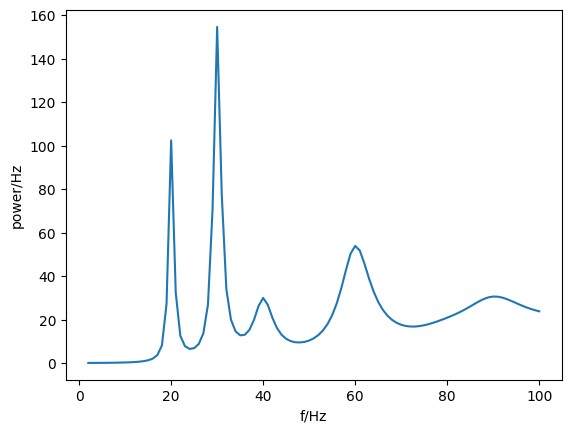

In [118]:
plot_spectrum(f_th*pq.Hz, psd_th*pq.dimensionless)


## Summary

Now, let's produce some summary plots of the different PSD estimates and compare them to the thoery.

Text(0.5, 0, 'f/Hz')

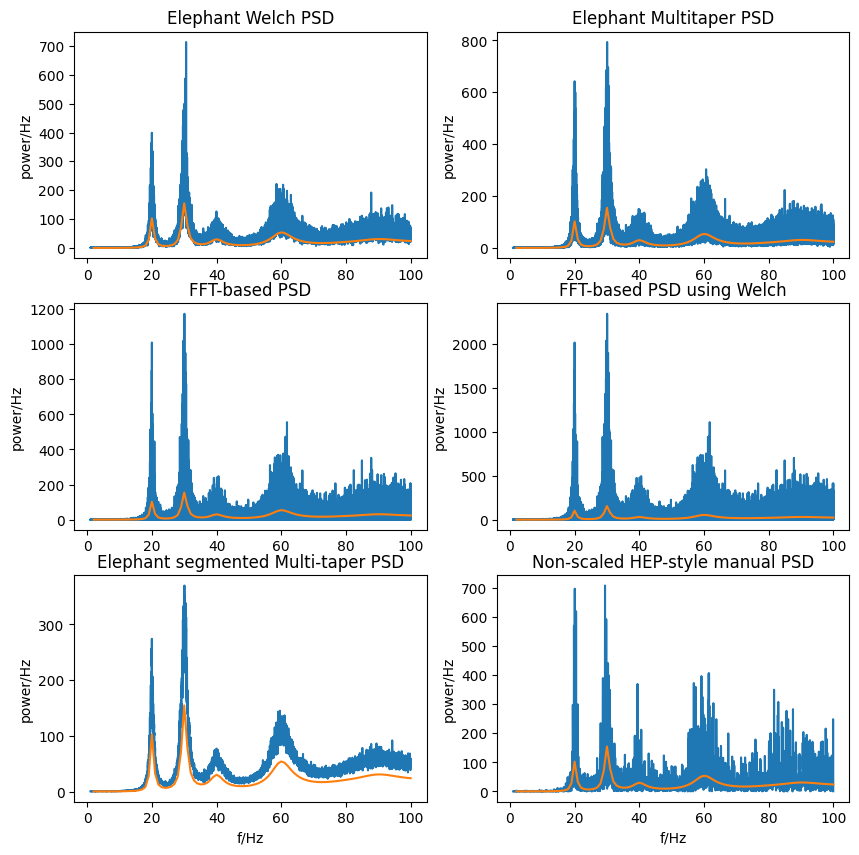

In [131]:
# f axis range to plot
min_f = 1
max_f = 100

# lmits for theoretical spectrum
lower_f_th_index = np.where(f_th>min_f)[0][0]
upper_f_th_index = np.where(f_th>max_f)[0][0]

fig, ax = plt.subplots(3,2,figsize=(10,10))
plt.sca(ax[0,0])
plot_spectrum(f_w, psd_w)
plot_spectrum(f_th*pq.Hz, psd_th*pq.dimensionless)
plt.title("Elephant Welch PSD")
plt.xlabel("")

plt.sca(ax[0,1])
plot_spectrum(f_mt, psd_mt)
plot_spectrum(f_th*pq.Hz, psd_th*pq.dimensionless)
plt.title("Elephant Multi-taper PSD")
plt.xlabel("")

plt.sca(ax[1,0])
plot_spectrum(f_fft*pq.Hz, psd_fft*pq.dimensionless)
plot_spectrum(f_th*pq.Hz, psd_th*pq.dimensionless)
plt.title("FFT-based PSD")
plt.xlabel("")

plt.sca(ax[1,1])
plot_spectrum(f_wfft, psd_wfft)
plot_spectrum(f_th*pq.Hz, psd_th*pq.dimensionless)
plt.title("FFT-based PSD using Welch")
plt.xlabel("")

plt.sca(ax[2,0])
plot_spectrum(f_mtn, psd_mtn[0,:])
plot_spectrum(f_th*pq.Hz, psd_th*pq.dimensionless)
plt.title("Elephant Segmented Multi-taper PSD")
plt.xlabel("f/Hz")

plt.sca(ax[2,1])
plot_spectrum(f_zf*pq.Hz, psd_zf*pq.dimensionless)
plot_spectrum(f_th*pq.Hz, psd_th*pq.dimensionless)
plt.title("PSD without binning")
plt.xlabel("f/Hz")

# Peak width comparison of smoothed PSDs

Text(0.5, 1.0, 'Comparison of the peak normalized to max, smoothed by $s$ bins')

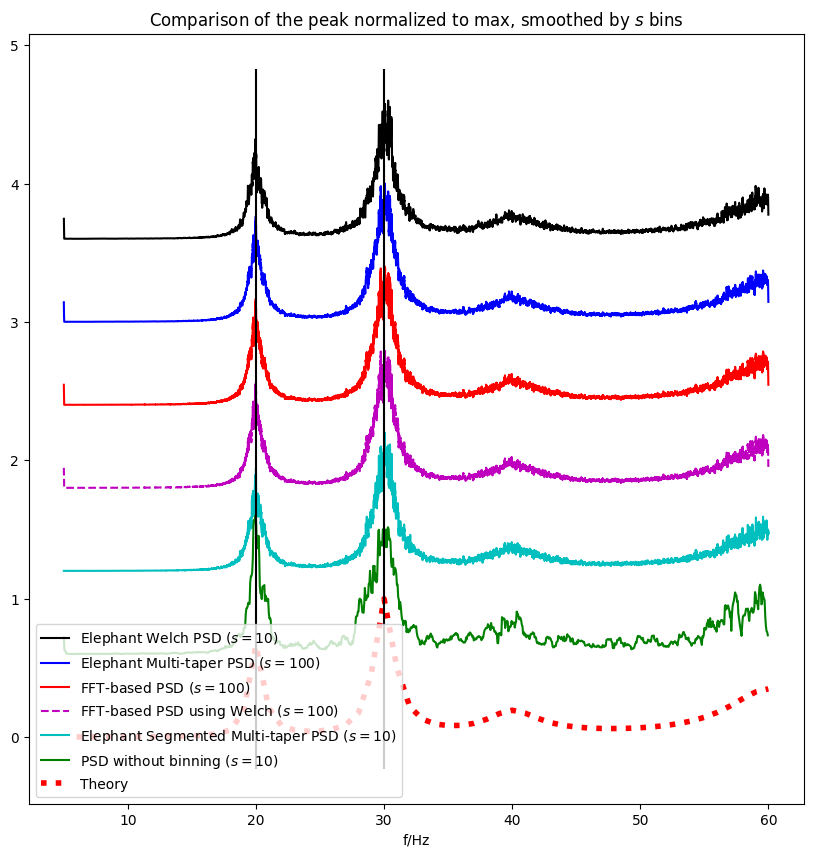

In [162]:
fig = plt.figure(figsize=(10,10))
smooth = 100
min_f = 5
max_f = 60
label = []
spacing = .6

lower_f_index = np.where(f_w.rescale(pq.Hz).magnitude>min_f)[0][0]
upper_f_index = np.where(f_w.rescale(pq.Hz).magnitude>max_f)[0][0]
x=movav(psd_w[0, lower_f_index:upper_f_index]/2,smooth//n_segments,1)
xm=np.max(x)
plt.plot(f_w[lower_f_index:upper_f_index], np.transpose(x/xm) + 6*spacing, "k-")
label.append(f"Elephant Welch PSD ($s={(smooth/n_segments):n}$)")

lower_f_index = np.where(f_mt.rescale(pq.Hz).magnitude>min_f)[0][0]
upper_f_index = np.where(f_mt.rescale(pq.Hz).magnitude>max_f)[0][0]
x=movav(psd_mt[0, lower_f_index:upper_f_index]/2,smooth,1)
xm=np.max(x)
plt.plot(f_mt[lower_f_index:upper_f_index], np.transpose(x/xm) + 5*spacing, "b-")
label.append(f"Elephant Multi-taper PSD ($s={smooth}$)")

lower_f_index = np.where(f_fft>min_f)[0][0]
upper_f_index = np.where(f_fft>max_f)[0][0]
x=movav(psd_fft[0, lower_f_index:upper_f_index],smooth,1)
xm=np.max(x)
plt.plot(f_fft[lower_f_index:upper_f_index], np.transpose(x/xm) + 4*spacing, "r-")
label.append(f"FFT-based PSD ($s={smooth}$)")

lower_f_index = np.where(f_wfft.rescale(pq.Hz).magnitude>min_f)[0][0]
upper_f_index = np.where(f_wfft.rescale(pq.Hz).magnitude>max_f)[0][0]
x=movav(psd_wfft[0, lower_f_index:upper_f_index]/2,smooth,1)
xm=np.max(x)
plt.plot(f_wfft[lower_f_index:upper_f_index], np.transpose(x/xm) + 3*spacing, "m--")
label.append(f"FFT-based PSD using Welch ($s={smooth}$)")

lower_f_index = np.where(f_mtn.rescale(pq.Hz).magnitude>min_f)[0][0]
upper_f_index = np.where(f_mtn.rescale(pq.Hz).magnitude>max_f)[0][0]
x=movav(psd_mtn[0, 0, lower_f_index:upper_f_index]/2,smooth/n_segments,1)
x=psd_mtn[0, 0, lower_f_index:upper_f_index]/2
xm=np.max(x)
plt.plot(f_mtn[lower_f_index:upper_f_index], np.transpose(x/xm)  + 2*spacing, "c-")
label.append(f"Elephant Segmented Multi-taper PSD ($s={(smooth/n_segments):n}$)")

lower_f_index = np.where(f_zf>min_f)[0][0]
upper_f_index = np.where(f_zf>max_f)[0][0]
x=movav(psd_zf[0, lower_f_index:upper_f_index],smooth/10,1)
xm=np.max(x)
plt.plot(f_zf[lower_f_index:upper_f_index], np.transpose(x/xm) + 1*spacing, "g-")
label.append(f"PSD without binning ($s={smooth/10:n}$)")

lower_f_index = np.where(f_th>min_f)[0][0]
upper_f_index = np.where(f_th>max_f)[0][0]
x=psd_th[0, lower_f_index:upper_f_index]
xm=np.max(x)
plt.plot(f_th[lower_f_index:upper_f_index], np.transpose(x/xm), "r:", linewidth=4)
label.append("Theory")

plt.vlines([rate_1.rescale(pq.Hz).magnitude, rate_2.rescale(pq.Hz).magnitude],
           plt.gca().get_ylim()[0],
           plt.gca().get_ylim()[1],colors=["k","k"])
plt.xlabel("f/Hz")
plt.legend(label)
plt.title(f"Comparison of the peak normalized to max, smoothed by $s$ bins")